In [1]:
data = "../data/"

In [2]:
!ls {data}

GTEX_sample_info_phenotypes.txt       chrM_2617.counts                      snyder_RNAseq_real_heteroplasmies.txt srt.chrM_SRR2164514.kallisto.bam
RNA_2617.txt                          chrM_2617.counts-initialset           snyder_phenotype.txt                  srt.chrM_SRR2164514.kallisto.bam.bai
SRR2165704_ref-hg_chrM_mapped.bam     phenotypes.txt                        snyder_rnaseq_20_timepoints.counts    srt.chrM_SRR2170756.kallisto.bam
SRR2165704_ref-mt_chrM_mapped.bam     rCRS.gb                               srt.chrM_SRR2156397.kallisto.bam      srt.chrM_SRR2170756.kallisto.bam.bai
chrM_2617.brain.counts                snyder_RNAseq_2617.txt                srt.chrM_SRR2156397.kallisto.bam.bai


In [3]:
#! for sra in $(cut -f 1 ../data/snyder_RNAseq_2617.txt);do echo|awk -v SRA=$sra 'BEGIN{OFS="\t"}{print "SNYDER",SRA,"Snyder","SNYDER","Self",1,60,3,0,25,"Alive","Alive"}';done > ../snyder_phenotype.txt

In [4]:
#! cat ../data/GTEX_sample_info_phenotypes.txt ../snyder_phenotype.txt > ../data/phenotypes.txt

In [5]:
! cat ../data/chrM_2617.counts ../data/snyder_RNAseq_2617.txt > ../data/RNA_2617.txt

In [6]:
import pandas as pd

In [7]:
counts = pd.read_table(data+"/RNA_2617.txt",header=None)

In [8]:
counts = counts.drop_duplicates()

In [9]:
counts.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,SRR1068687,chrM,2617,2044,36,1171,3385,1927,35,982,3027,12607,4,T,A,0.31498
1,SRR1068788,chrM,2617,2828,26,621,1671,3327,31,629,1512,10645,4,A,T,0.29901


In [10]:
counts.columns = ["sra_id","reference","position","A","C","G","T","a","c","g","t","coverage","n_alleles","major_allele",
               "minor_allele","MAF"]

In [11]:
counts.head(2)

,sra_id,reference,position,A,C,G,T,a,c,g,t,coverage,n_alleles,major_allele,minor_allele,MAF
0,SRR1068687,chrM,2617,2044,36,1171,3385,1927,35,982,3027,12607,4,T,A,0.31498
1,SRR1068788,chrM,2617,2828,26,621,1671,3327,31,629,1512,10645,4,A,T,0.29901


In [12]:
counts = counts[counts.coverage>=1000]

In [13]:
def non_A(s):
    freq_A = (s['A']+s['a'])/float(s['coverage'])
    freq_mod = (s['T']+s['t']+s['G']+s['g'])/float(s['coverage'])
    delta = freq_mod - freq_A
    return pd.Series([s['sra_id'],freq_A,freq_mod,delta])

In [14]:
frequencies = counts.apply(non_A, axis=1)
frequencies.columns = ["sra_id","freq_A","freq_TG","TG-A"]

In [15]:
frequencies.head()

,sra_id,freq_A,freq_TG,TG-A
0,SRR1068687,0.314984,0.679384,0.364401
1,SRR1068788,0.578206,0.416440,-0.161766
2,SRR1068832,0.521338,0.474241,-0.047097
3,SRR1068855,0.541436,0.452594,-0.088842
4,SRR1068905,0.621851,0.374591,-0.247260


In [16]:
phenotypes = pd.read_table(data+"/phenotypes.txt", header=None)

In [17]:
phenotypes.tail(2)

,0,1,2,3,4,5,6,7,8,9,10,11
3300,SNYDER,SRR353653,Snyder,SNYDER,Self,1,60,3,0,25,Alive,Alive
3301,SNYDER,SRR353654,Snyder,SNYDER,Self,1,60,3,0,25,Alive,Alive


In [18]:
phenotypes = phenotypes.drop([3],axis=1)

In [19]:
phenotypes.columns = ["subject","sra_id","tissue","collection","gender","age","race","ethnicity","BMI","COD","TOD"]

In [20]:
phenotypes.head(2)

,subject,sra_id,tissue,collection,gender,age,race,ethnicity,BMI,COD,TOD
0,GTEX-PW2O,SRR598484,Lung,Organ Donor (OPO),1,23,3,0,29.56,Blunt Injury,Accident
1,GTEX-NPJ8,SRR598124,Brain - Amygdala,Postmortem,1,40,3,98,27.89,Hepatorenal Syndrome,Natural


In [21]:
merged = pd.merge(phenotypes,frequencies,on =["sra_id"])

In [22]:
merged.head(2)

,subject,sra_id,tissue,collection,gender,age,race,ethnicity,BMI,COD,TOD,freq_A,freq_TG,TG-A
0,GTEX-PW2O,SRR598484,Lung,Organ Donor (OPO),1,23,3,0,29.56,Blunt Injury,Accident,0.362534,0.629859,0.267324
1,GTEX-NPJ8,SRR598124,Brain - Amygdala,Postmortem,1,40,3,98,27.89,Hepatorenal Syndrome,Natural,0.512103,0.482601,-0.029502


In [23]:
#brain_only = merged[merged.tissue.str.contains("Brain")]
#temporal = merged
#merged = brain_only

In [24]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt


In [25]:
def stat_test(a,b):
    stat,pval = list(stats.ttest_rel(a,b))
    return pval

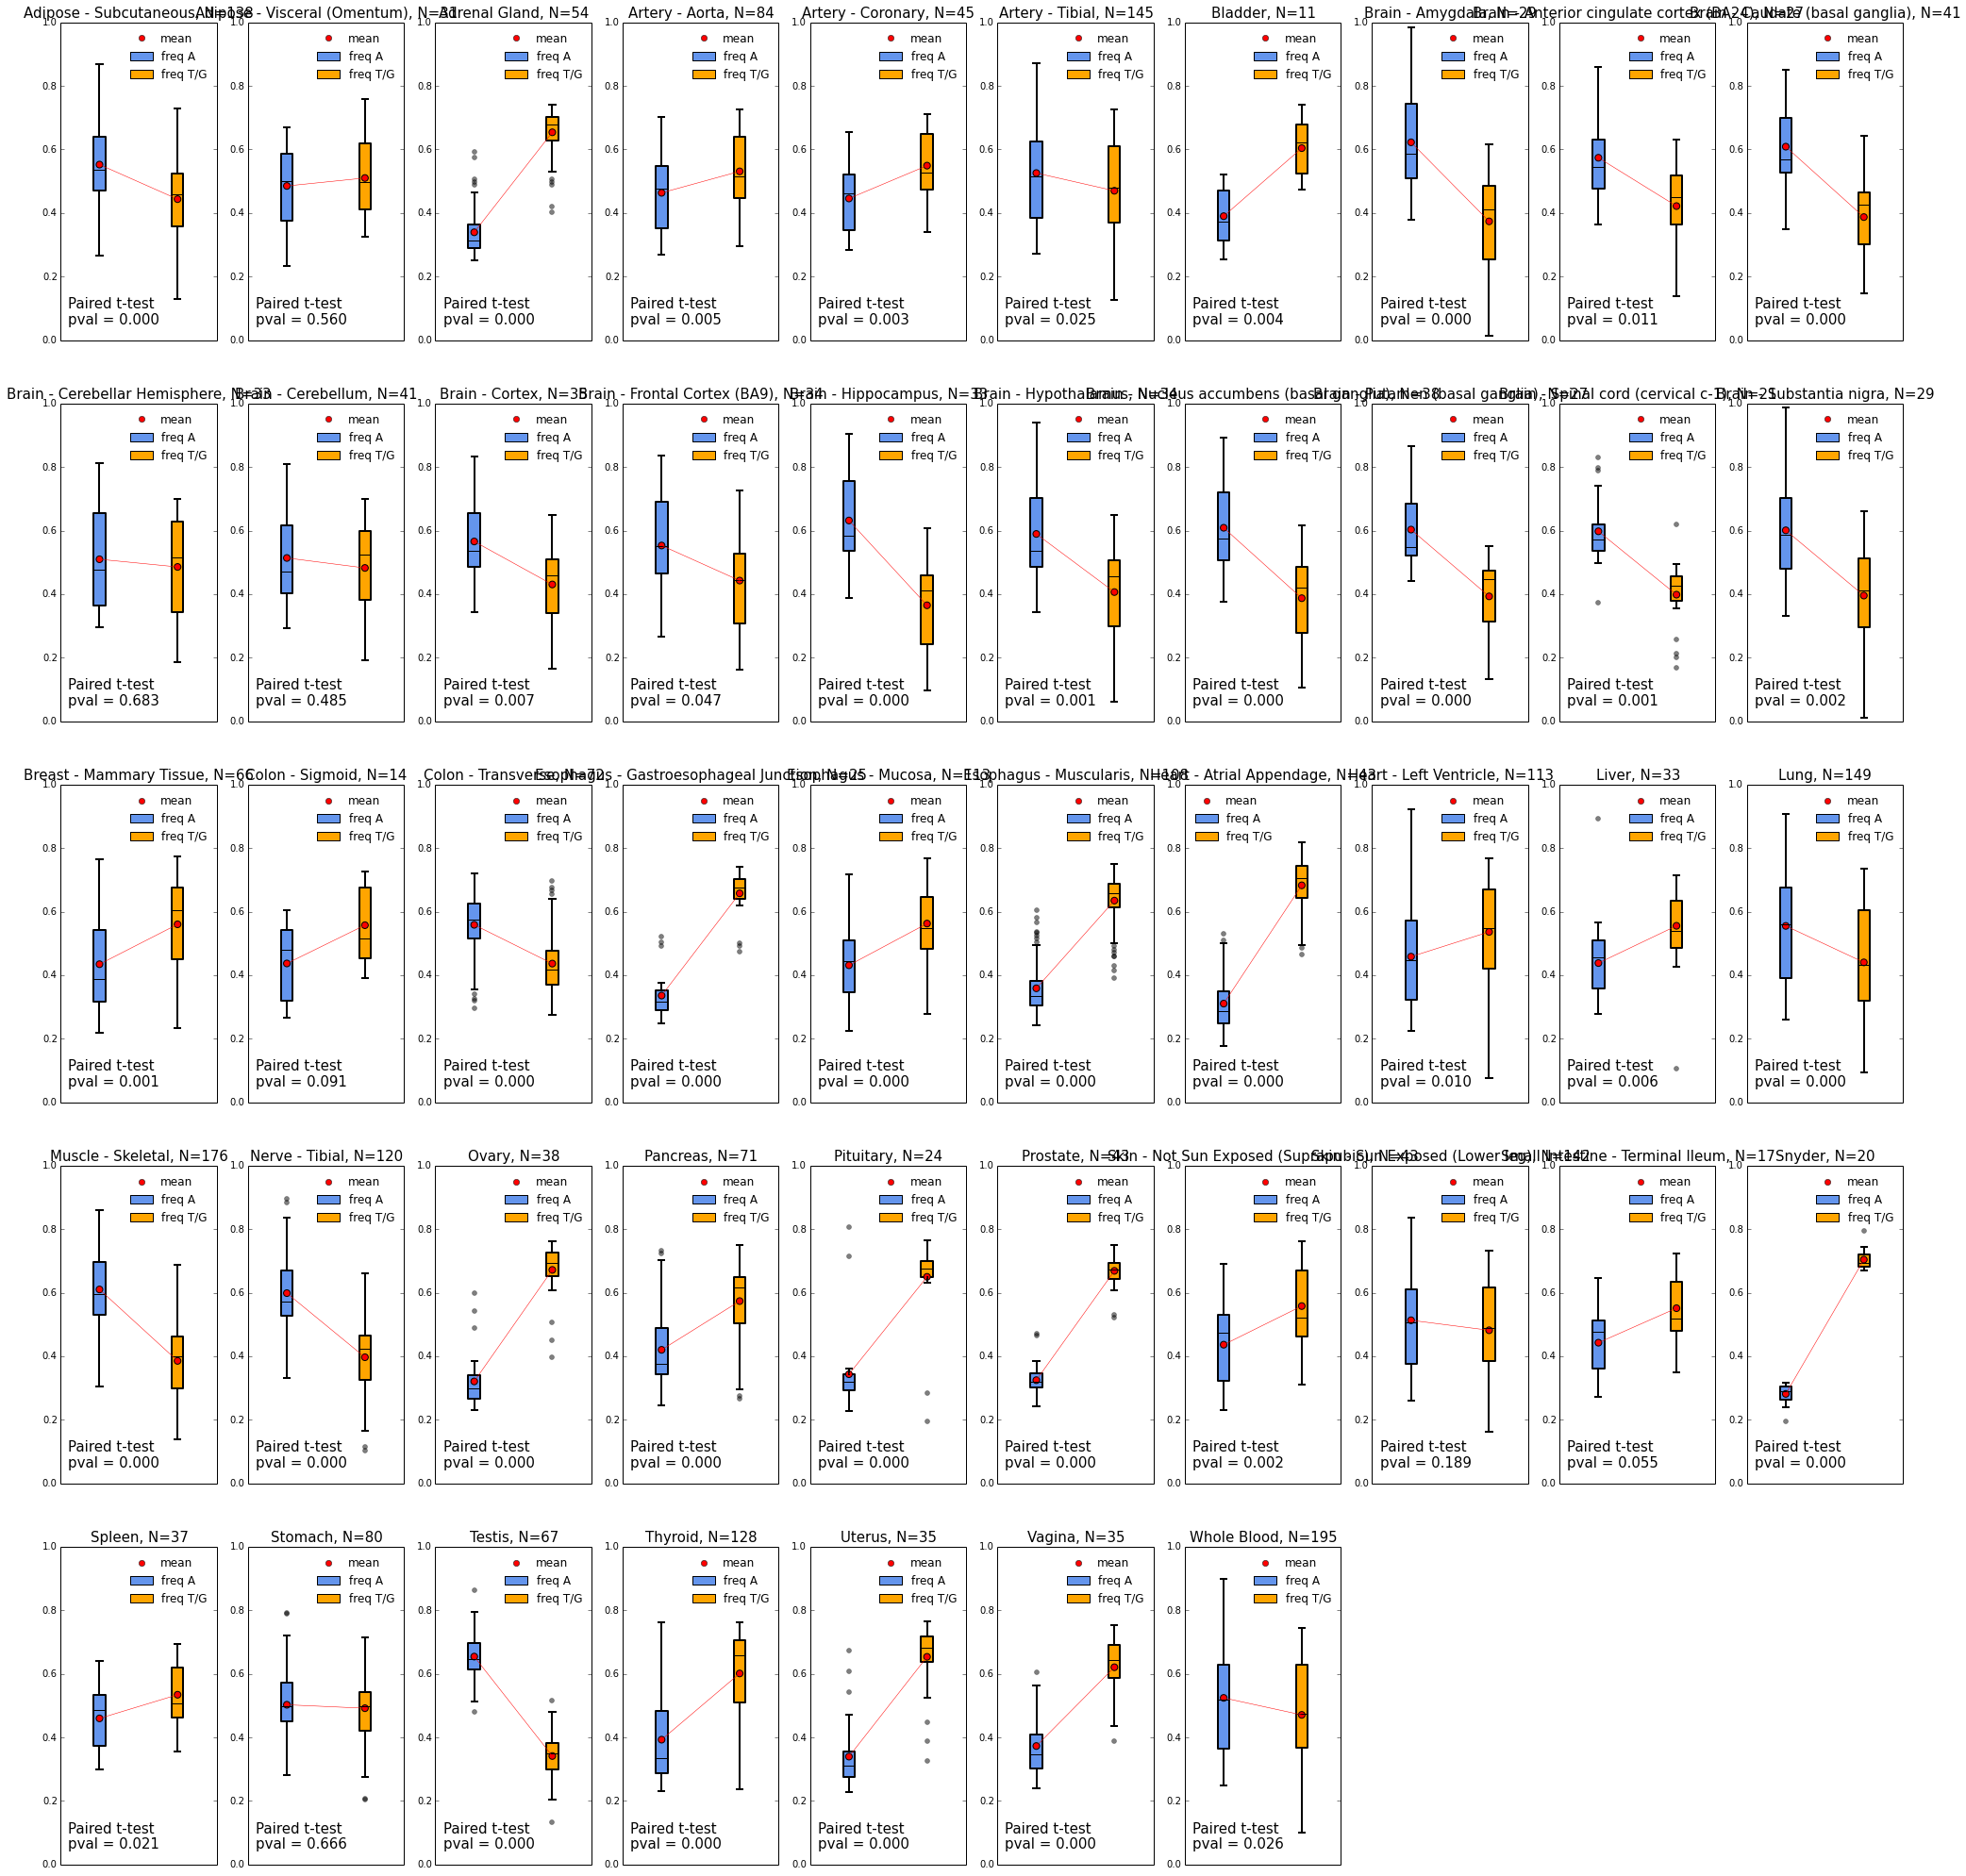

In [26]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (35, 35)

n=0
for tissue,df in merged.groupby(["tissue"]):
    if len(df)>=10:
    
        n+=1
        PLOT = plt.subplot(5,10,n)
        plt.title("%s, N=%d" % (tissue,len(df)),size=15)
        plt.ylim([0,1])
        

        current = df.boxplot(column=["freq_A","freq_TG"],grid=False, return_type='dict', patch_artist=True)
        
        means = [np.mean(x) for x in [df.freq_A,df.freq_TG]]
        plt.scatter([1,2],means,color="red",s=50,zorder=2,edgecolor="black")
        plt.plot([1,2],means,color="red",linewidth=0.5)
    
        colors = ["cornflowerblue","orange"]
        for patch, color in zip(current['boxes'], colors):
            patch.set_facecolor(color)
 
        plt.setp(current['whiskers'], linestyle='-', color="black", linewidth=2)
        plt.setp(current['fliers'], marker='o', markersize=5,alpha=0.5,color="black")
        plt.setp(current['medians'], linestyle='-', color="black")
        plt.setp(current['boxes'],linewidth=2,edgecolor='black')
        plt.setp(current['caps'],linewidth=2)
        
        plt.text(0.6,0.1, "Paired t-test",size=15)
        plt.text(0.6,0.05, "pval = %.3f" % stat_test(df.freq_A,df.freq_TG),size=15)
        
        
        l1 = plt.Rectangle((0, 0), 1, 1, fc="cornflowerblue")
        l2 = plt.Rectangle((0, 0), 1, 1, fc="orange")
        l3 = plt.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="red")
        
        plt.legend((l3, l1,l2), ('mean','freq A', 'freq T/G'), loc='best',frameon=False,numpoints=1)
        
        PLOT.axes.get_xaxis().set_ticks([])
        

        

       



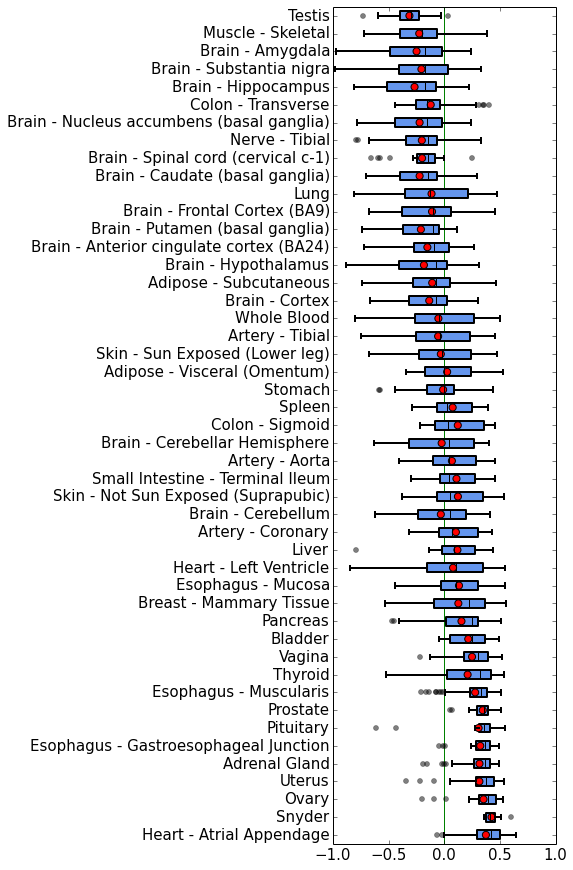

In [27]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (4, 15)

nsamplethres=10

df2 = pd.DataFrame({tissue:df['TG-A'] for tissue,df in merged.groupby(['tissue']) if len(df)>=nsamplethres})

medians = df2.median()
medians.sort_values(ascending=False, inplace=True)
df2 = df2[medians.index]
means = df2.mean()

BOX=df2.boxplot(return_type='dict',rot=0,patch_artist=True,grid=False, vert=False)
colors = ['cornflowerblue']*len(medians)
for patch, color in zip(BOX['boxes'], colors):
            patch.set_facecolor(color)
        

plt.scatter(y=range(1,len(means)+1),x=means,color="red",s=50,zorder=2,edgecolor="black")
        
plt.setp(BOX['whiskers'], linestyle='-', color="black", linewidth=2)
plt.setp(BOX['fliers'], marker='o', markersize=5,alpha=0.5,color="black")
plt.setp(BOX['medians'], linestyle='-', color="black")
plt.setp(BOX['boxes'],linewidth=2,edgecolor='black')
plt.setp(BOX['caps'],linewidth=2)

plt.xlim([-1,1])
plt.yticks(size=15)
plt.xticks(size=15)
plt.axvline(linewidth=1,zorder=0,color="green")

In [28]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [29]:
test_data = merged[merged.tissue.isin(list(df2.columns))][['tissue','TG-A']]
test_data.columns = ['tissue','delta']
lm = ols('delta ~ C(tissue)',data=test_data).fit()
table = sm.stats.anova_lm(lm, typ=2)
print table

               sum_sq    df          F         PR(>F)
C(tissue)   97.652330    46  32.067513  2.479055e-221
Residual   191.318668  2890        NaN            NaN


In [30]:
test_tissues = test_data.tissue.drop_duplicates()


tmp = []

for t1 in test_tissues:
    for t2 in test_tissues:
        if t1!=t2:
            tmp.append((t1,t2))

comparisons = []
for t in tmp:
    if t not in comparisons and t[::-1] not in comparisons:
        comparisons.append(t)


In [31]:
pairwise = []

for t1,t2 in comparisons:
    a = test_data[test_data.tissue==t1].delta
    b = test_data[test_data.tissue==t2].delta
    pval = stats.ttest_ind(a,b)[1]
    if pval<= (0.05/len(comparisons)):
        pairwise.append((t1,t2,"%.3e" % pval))

In [32]:
if pairwise:
    pairwise_t=pd.DataFrame(pairwise)
    pairwise_t.columns=['Tissue_1','Tissue_2','adj_pval']
    pairwise_t.sort_values(by=['Tissue_1'])
else:
    print "No significant differences"
        

In [33]:
pairwise_t.sort_values(by=['Tissue_2'])

,Tissue_1,Tissue_2,adj_pval
163,Thyroid,Adipose - Subcutaneous,1.462e-17
255,Heart - Left Ventricle,Adipose - Subcutaneous,9.716e-07
418,Heart - Atrial Appendage,Adipose - Visceral (Omentum),3.114e-10
271,Muscle - Skeletal,Adipose - Visceral (Omentum),3.236e-07
379,Nerve - Tibial,Adipose - Visceral (Omentum),4.995e-06
348,Brain - Hippocampus,Adipose - Visceral (Omentum),3.716e-05
113,Whole Blood,Adrenal Gland,1.000e-13
462,Artery - Coronary,Adrenal Gland,2.678e-07
304,Adipose - Subcutaneous,Adrenal Gland,1.955e-21
494,Colon - Transverse,Adrenal Gland,3.734e-26


In [34]:
df2.count()

Heart - Atrial Appendage                      43
Snyder                                        20
Ovary                                         38
Uterus                                        35
Adrenal Gland                                 54
Esophagus - Gastroesophageal Junction         25
Pituitary                                     24
Prostate                                      43
Esophagus - Muscularis                       108
Thyroid                                      128
Vagina                                        35
Bladder                                       11
Pancreas                                      71
Breast - Mammary Tissue                       66
Esophagus - Mucosa                           113
Heart - Left Ventricle                       113
Liver                                         33
Artery - Coronary                             45
Brain - Cerebellum                            41
Skin - Not Sun Exposed (Suprapubic)           43
Small Intestine - Te